In [1]:
!git clone https://github.com/microsoft/qlib.git
!cd qlib && pip install . -q
!pip install -q moexalgo

Cloning into 'qlib'...
remote: Enumerating objects: 17532, done.
remote: Counting objects: 100% (8777/8777), done.
remote: Compressing objects: 100% (2516/2516), done.
remote: Total 17532 (delta 6687), reused 6524 (delta 6242), pack-reused 8755
Receiving objects: 100% (17532/17532), 16.63 MiB | 3.61 MiB/s, done.
Resolving deltas: 100% (12770/12770), done.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
apache-beam 2.46.0 requires pymongo<4.0.0,>=3.8.0, but you ha

In [2]:
!mkdir /kaggle/working/moex_data_hours
!mkdir /kaggle/working/hours

In [3]:
import qlib
import yaml
import pandas as pd
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from moexalgo import Ticker
import seaborn as sns
import warnings

warnings.simplefilter('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def get_stats(ticker, period, coeff, date='2023-01-01', till_date='2023-12-01'):
    
    stats_dataset = Ticker(ticker).candles(date=date, till_date=till_date, period=period)
    
    stats_dataset['date'] = stats_dataset['end']
    stats_dataset = stats_dataset[['date', 'open', 'close', 'high', 'low', 'volume', 'value']]
    stats_dataset[['open', 'close', 'high', 'low', 'value']] *= coeff

    return stats_dataset

In [6]:
stocks = ["GAZP", "SBER", "LKOH", "SNGS", "CHMF", "YNDX", "GMKN", "MOEX", "MTSS", "TCSG", "ROSN", "ALRS", "PHOR", "PLZL", "RUAL", "TATN", "POLY", "NVTK"]
coeffs = [10, 10, 1, 100, 1, 1, 1, 10, 10, 1, 1, 10, 1, 1, 10, 1, 1, 1]

end_date = datetime.strptime('2023-12-09', '%Y-%m-%d')

for stock, coeff in zip(stocks, coeffs):
    print(stock)
    
    ticker_df = pd.DataFrame()
    date = datetime.strptime('2020-01-01', '%Y-%m-%d')
    
    while date < end_date:
        
        till_date = date + relativedelta(months=6)
        df = get_stats(stock, '1h', coeff, date=date, till_date=till_date)
        ticker_df = pd.concat((ticker_df, df))
        
        date = till_date + timedelta(days=1)
        
    ticker_df.to_csv(f'/kaggle/working/hours/{stock}.csv', index=False)

GAZP
SBER
LKOH
SNGS
CHMF
YNDX
GMKN
MOEX
MTSS
TCSG
ROSN
ALRS
PHOR
PLZL
RUAL
TATN
POLY
NVTK


In [7]:
dates_range = pd.read_csv(f'/kaggle/working/hours/{stocks[0]}.csv')['date'].copy().astype(str).values

start_point = dates_range[0]
end_point = '2023-11-01'

quant = int(len(dates_range) * 0.33)
first_point = dates_range[-quant]
second_point = dates_range[-quant + 1]
third_point = dates_range[-quant // 2]
forth_point = dates_range[-quant // 2 + 1]

In [8]:
!python qlib/scripts/dump_bin.py dump_all --csv_path /kaggle/working/hours --qlib_dir /kaggle/working/moex_data_hours

2023-12-10 08:12:28.008 | INFO     | __main__:_get_all_date:275 - start get all date......
100%|███████████████████████████████████████████| 18/18 [00:01<00:00, 11.46it/s]
2023-12-10 08:12:29.580 | INFO     | __main__:_get_all_date:294 - end of get all date.

2023-12-10 08:12:29.582 | INFO     | __main__:_dump_calendars:297 - start dump calendars......
2023-12-10 08:12:29.765 | INFO     | __main__:_dump_calendars:300 - end of calendars dump.

2023-12-10 08:12:29.765 | INFO     | __main__:_dump_instruments:303 - start dump instruments......
2023-12-10 08:12:29.766 | INFO     | __main__:_dump_instruments:305 - end of instruments dump.

2023-12-10 08:12:29.766 | INFO     | __main__:_dump_features:308 - start dump features......
100%|███████████████████████████████████████████| 18/18 [00:01<00:00, 11.06it/s]
2023-12-10 08:12:31.394 | INFO     | __main__:_dump_features:315 - end of features dump.



In [9]:
from qlib.contrib.data.handler import Alpha158
from qlib.contrib.strategy import TopkDropoutStrategy
from qlib.strategy.base import BaseStrategy
from qlib.utils import exists_qlib_data, init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
from qlib.utils import flatten_dict
import qlib.contrib.report as qcr
from qlib.utils.time import Freq
from qlib.backtest import backtest, executor
from qlib.contrib.evaluate import risk_analysis

(CVXPY) Dec 10 08:12:32 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')
(CVXPY) Dec 10 08:12:32 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')


In [10]:
provider_uri = '/kaggle/working/moex_data_hours'
qlib.init(provider_uri=provider_uri)

[42:MainThread](2023-12-10 08:12:33,077) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[42:MainThread](2023-12-10 08:12:33,083) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[42:MainThread](2023-12-10 08:12:33,085) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/kaggle/working/moex_data_hours')}


In [11]:
market = 'all'

path_to_config = 'examples/benchmarks/ALSTM/workflow_config_alstm_Alpha360.yaml'

with open('/kaggle/working/qlib/' + path_to_config, 'r') as file:
    configs = yaml.safe_load(file)

In [12]:
data_handler_config = {
    "start_time": start_point,"end_time": end_point,
    "fit_start_time": start_point,"fit_end_time": first_point,
    "instruments": market
}

task = {
    "dataset": {
        "kwargs": {
            "segments": {
                "train": (start_point, first_point),
                "valid": (second_point, third_point),
                "test": (forth_point, end_point),
            },
        },
    },
}

final_config = {}
final_config['model'] = configs['task']['model']
final_config['model']['kwargs']['lr'] = 1e-3
final_config['dataset'] = configs['task']['dataset']
final_config['dataset']['kwargs']['segments'] = task['dataset']['kwargs']['segments']

for attr in ['start_time', 'end_time', 'fit_start_time', 'fit_end_time', 'instruments']:
    final_config['dataset']['kwargs']['handler']['kwargs'][attr] = data_handler_config[attr]

In [13]:
model = init_instance_by_config(final_config["model"])
dataset = init_instance_by_config(final_config["dataset"])

with R.start(experiment_name="train_model"):
    R.log_params(**flatten_dict(final_config))
    model.fit(dataset)
    R.save_objects(trained_model=model)
    rid = R.get_recorder().id

[42:MainThread](2023-12-10 08:12:38,417) INFO - qlib.ALSTM - [pytorch_alstm.py:59] - ALSTM pytorch version...
[42:MainThread](2023-12-10 08:12:38,443) INFO - qlib.ALSTM - [pytorch_alstm.py:76] - ALSTM parameters setting:
d_feat : 6
hidden_size : 64
num_layers : 2
dropout : 0.0
n_epochs : 200
lr : 0.001
metric : loss
batch_size : 800
early_stop : 20
optimizer : adam
loss_type : mse
device : cuda:0
use_GPU : True
seed : None
[42:MainThread](2023-12-10 08:12:38,471) INFO - qlib.ALSTM - [pytorch_alstm.py:119] - model:
ALSTMModel(
  (net): Sequential(
    (fc_in): Linear(in_features=6, out_features=64, bias=True)
    (act): Tanh()
  )
  (rnn): GRU(64, 64, num_layers=2, batch_first=True)
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
  (att_net): Sequential(
    (att_fc_in): Linear(in_features=64, out_features=32, bias=True)
    (att_dropout): Dropout(p=0.0, inplace=False)
    (att_act): Tanh()
    (att_fc_out): Linear(in_features=32, out_features=1, bias=False)
    (att_soft

In [14]:
predicted = None

with R.start(experiment_name="predicting"):
    recorder = R.get_recorder(experiment_name="train_model")
    model = recorder.load_object("/kaggle/input/qlib-model-saving/trained_model")
    predicted = model.predict(dataset)

[42:MainThread](2023-12-10 08:14:40,775) WARNING - qlib.workflow - [expm.py:230] - No valid experiment found. Create a new experiment with name predicting.
[42:MainThread](2023-12-10 08:14:40,780) INFO - qlib.workflow - [exp.py:258] - Experiment 2 starts running ...
[42:MainThread](2023-12-10 08:14:40,793) INFO - qlib.workflow - [recorder.py:341] - Recorder bb2f19fdba5c44d0adf628cc90affab7 starts running under Experiment 2 ...
usage: git diff --no-index [<options>] <path> <path>

Diff output format options
    -p, --patch           generate patch
    -s, --no-patch        suppress diff output
    -u                    generate patch
    -U, --unified[=<n>]   generate diffs with <n> lines context
    -W, --function-context
                          generate diffs with <n> lines context
    --raw                 generate the diff in raw format
    --patch-with-raw      synonym for '-p --raw'
    --patch-with-stat     synonym for '-p --stat'
    --numstat             machine friendly --st

[42:MainThread](2023-12-10 08:14:54,638) WARNING - qlib.data - [data.py:666] - load calendar error: freq=day, future=True; return current calendar!
[42:MainThread](2023-12-10 08:14:54,640) WARNING - qlib.data - [data.py:669] - You can get future calendar by referring to the following document: https://github.com/microsoft/qlib/blob/main/scripts/data_collector/contrib/README.md
[42:MainThread](2023-12-10 08:14:54,787) WARNING - qlib.BaseExecutor - [executor.py:121] - `common_infra` is not set for <qlib.backtest.executor.SimulatorExecutor object at 0x79964d72c550>
[42:MainThread](2023-12-10 08:14:54,803) INFO - qlib.backtest caller - [__init__.py:93] - Create new exchange
[42:MainThread](2023-12-10 08:14:55,296) WARNING - qlib.online operator - [exchange.py:219] - $close field data contains nan.
[42:MainThread](2023-12-10 08:14:55,299) WARNING - qlib.online operator - [exchange.py:219] - $close field data contains nan.
[42:MainThread](2023-12-10 08:14:55,302) WARNING - qlib.online operat

backtest loop:   0%|          | 0/2507 [00:00<?, ?it/s]

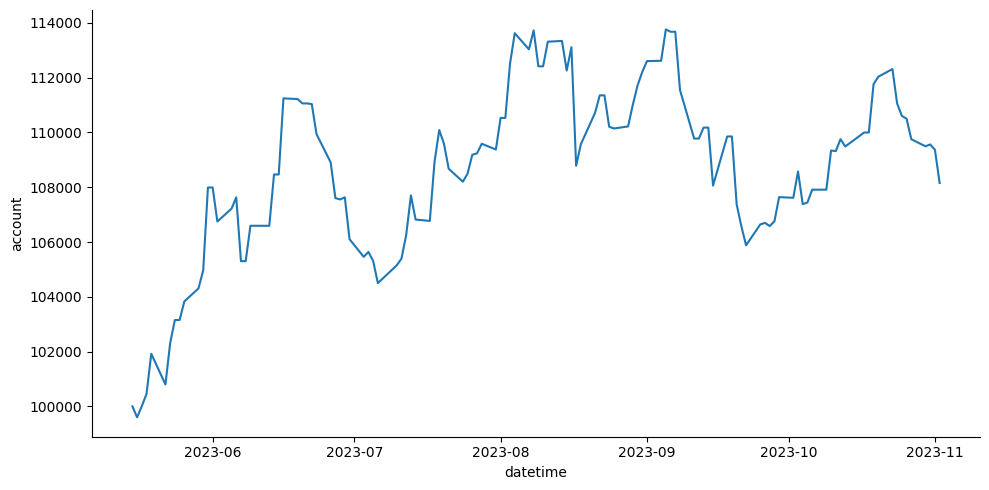

In [15]:
start_account = 100000

STRATEGY_CONFIG = {
    "topk": 8,
    "n_drop": 2,
    "signal": predicted,
}

EXECUTOR_CONFIG = {
    "class": "SimulatorExecutor",
    "module_path": "qlib.backtest.executor",
    "kwargs": {
        "time_per_step": "day",
        "generate_portfolio_metrics": True,
        "verbose": False,
    }
}

backtest_config = {
    "start_time": forth_point,
    "end_time": end_point,
    "account": start_account,
    "benchmark": 'YNDX',
    "exchange_kwargs": {
        "freq": 'day',
        "limit_threshold": 0.095,
        "deal_price": "close",
        "open_cost": 0.0005,
        "close_cost": 0.0015,
        "min_cost": 50,
    },
}

strategy_obj = TopkDropoutStrategy(**STRATEGY_CONFIG)

executor_obj = init_instance_by_config(EXECUTOR_CONFIG)

portfolio_metric_dict, indicator_dict = backtest(executor=executor_obj, strategy=strategy_obj, **backtest_config)
analysis_freq = "{0}{1}".format(*Freq.parse('day'))

report_normal_df, positions_normal = portfolio_metric_dict.get(analysis_freq)

sns.relplot(data=report_normal_df, x='datetime', y='account', kind='line', aspect=2)

In [31]:
def catch_changes(portfolio_before, portfolio_after):
    
    wallet_before = portfolio_before.get_stock_list()
    wallet_after = portfolio_after.get_stock_list()
    
    wallet_merged = set(wallet_after + wallet_before)
    wallet_before = set(wallet_before)
    
    return list(wallet_merged - wallet_before)

def get_prices(portfolio, stocks):
    
    prices = []
    
    for stock in stocks:
        prices.append(portfolio.get_stock_price(stock))
        
    return prices

In [36]:
timestamps = sorted(list(positions_normal.keys()))
portfolio = positions_normal[timestamps[0]]
market_actions = []

for timestamp in timestamps[1:]:
    
    next_portfolio = positions_normal[timestamp]
    
    purchased_stocks = catch_changes(portfolio, next_portfolio)
    sold_stocks = catch_changes(next_portfolio, portfolio)
    
    purchased_prices = get_prices(next_portfolio, purchased_stocks)
    sold_prices = get_prices(portfolio, sold_stocks)
    
    purchased_stocks = [{'ticker': stock, 'price': price} for stock, price in zip(purchased_stocks, purchased_prices)]
    sold_stocks = [{'ticker': stock, 'price': price} for stock, price in zip(sold_stocks, sold_prices)]
    
    market_actions.append(
        {
            'bought': purchased_stocks,
            'sold': sold_stocks
        }
    )
    portfolio = next_portfolio

In [37]:
market_actions

[{'bought': [{'ticker': 'POLY', 'price': 681.7999877929688},
   {'ticker': 'LKOH', 'price': 4960.0},
   {'ticker': 'TATN', 'price': 402.20001220703125},
   {'ticker': 'ROSN', 'price': 404.8999938964844},
   {'ticker': 'MTSS', 'price': 2842.0},
   {'ticker': 'YNDX', 'price': 2032.5999755859375},
   {'ticker': 'SBER', 'price': 2292.800048828125},
   {'ticker': 'SNGS', 'price': 2509.0}],
  'sold': []},
 {'bought': [{'ticker': 'CHMF', 'price': 1005.0},
   {'ticker': 'TCSG', 'price': 2808.5}],
  'sold': [{'ticker': 'SBER', 'price': 2292.800048828125},
   {'ticker': 'SNGS', 'price': 2509.0}]},
 {'bought': [{'ticker': 'ALRS', 'price': 673.4000244140625},
   {'ticker': 'MOEX', 'price': 1120.9000244140625}],
  'sold': [{'ticker': 'YNDX', 'price': 2032.4000244140625},
   {'ticker': 'POLY', 'price': 677.5999755859375}]},
 {'bought': [], 'sold': []},
 {'bought': [{'ticker': 'YNDX', 'price': 2205.800048828125},
   {'ticker': 'SNGS', 'price': 2423.0}],
  'sold': [{'ticker': 'CHMF', 'price': 1005.799